In [1]:
import pandas as pd
import numpy as np
import mlfinlab as ml
import matplotlib.pyplot as plt
import fastparquet

import pyfolio as pf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

DIR = 'data/10min/'

/home/dan/Apps/anaconda3/envs/financial-ml/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


## 0. How to use meta-labeling

First, we build a model that acieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase the F!-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is *not* its purpose to come up with a betting opportunity. Its purpose is to determine whether we should act or pass on the opportunity that has been presented.

In [2]:
df = pd.read_parquet(DIR + 'dollar.parq')['2018':'2019']
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2018-01-01 00:11:11.241,3381,13873.0,13920.0,13675.0,13763.5,678.428823,196.744402,3381,9.339762e+06
2018-01-01 00:27:14.652,6433,13763.5,13789.5,13596.0,13775.5,681.928406,359.159578,3052,9.340538e+06
2018-01-01 00:48:23.395,9291,13775.5,13780.5,13657.0,13745.0,681.494038,396.172220,2858,9.345154e+06
2018-01-01 01:09:43.777,12668,13745.0,13770.0,13555.5,13555.5,684.667367,253.573044,3377,9.341081e+06
2018-01-01 01:32:03.253,15130,13555.5,13737.5,13550.0,13650.5,690.498692,427.242852,2462,9.420639e+06


In [3]:
df = df[['high', 'low', 'close', 'volume', 'cum_dollar_value']]
df.columns = ['high', 'low', 'close', 'btc_volume', 'dollar_volume']

In [4]:
def fix_duplicated_indices(df):
    df.reset_index(inplace=True)
    deltas = pd.to_timedelta(df.groupby('date_time').cumcount(), unit='micro')
    df['date_time'] = df['date_time'] + deltas
    df.set_index('date_time', inplace=True)
    
    assert df.index.duplicated().sum() == 0

In [5]:
if df.index.duplicated().sum() > 0:
    fix_duplicated_indices(df)

## 1. Primary Model - SMA Crossover

Get the sides of the trades using the SMA Crossover strategy.

The trader should go long on a stock when the shorter-term SMA is above the longer-term SMA and should go short when the opposite holds true.

In [6]:
short_window = 20
long_window = 50

df['short_sma'] = df.close.rolling(window = short_window,
                                  center = False).mean()
df['long_sma'] = df.close.rolling(window = long_window,
                                 center = False).mean()

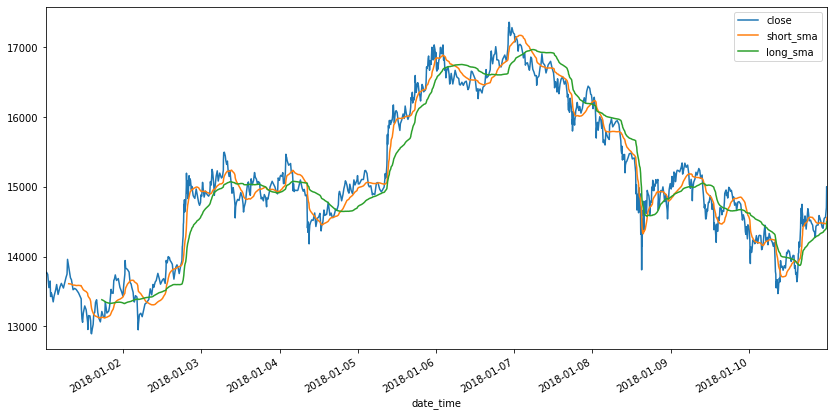

In [7]:
df[['close', 'short_sma', 'long_sma']].loc['2018-01-01':'2018-01-10'].plot(figsize=(14, 7))

In [8]:
# compute sides
df['side'] = np.nan

long_signals = df['short_sma'] >= df['long_sma']
short_signals = df['short_sma'] < df['long_sma']
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# remove look ahead bias by laggin the signal
df['side'] = df['side'].shift(1)

In [9]:
df

,high,low,close,btc_volume,dollar_volume,short_sma,long_sma,side
date_time,,,,,,,,
2018-01-01 00:11:11.241,13920.0,13675.0,13763.5,678.428823,9.339762e+06,NaN,NaN,NaN
2018-01-01 00:27:14.652,13789.5,13596.0,13775.5,681.928406,9.340538e+06,NaN,NaN,NaN
2018-01-01 00:48:23.395,13780.5,13657.0,13745.0,681.494038,9.345154e+06,NaN,NaN,NaN
2018-01-01 01:09:43.777,13770.0,13555.5,13555.5,684.667367,9.341081e+06,NaN,NaN,NaN
2018-01-01 01:32:03.253,13737.5,13550.0,13650.5,690.498692,9.420639e+06,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-04-30 22:56:45.216,5273.0,5264.5,5271.0,1773.505975,9.345586e+06,5251.225,5247.79,1.0
2019-04-30 23:06:44.670,5275.5,5270.0,5270.0,1773.032423,9.349355e+06,5252.900,5248.15,1.0
2019-04-30 23:14:24.220,5270.0,5263.5,5263.5,1774.815981,9.346254e+06,5254.050,5248.19,1.0


In [10]:
raw_data = df.copy()

df.dropna(axis=0, how='any', inplace=True)

In [11]:
df.side.value_counts()

 1.0    54057
-1.0    52347
Name: side, dtype: int64

## 2. Label the events using the Triple-Barrier method

In [12]:
daily_volatility = ml.util.get_daily_vol(close=df.close, lookback=100)

In [13]:
cusum_events = ml.filters.cusum_filter(df.close, threshold=daily_volatility)

In [14]:
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                    close=df.close,
                                                    num_days=1)

In [15]:
pt_sl = [1, 1]
min_ret = 0.005,

triple_barrier_events = ml.labeling.get_events(close=df.close,
                                              t_events=cusum_events,
                                              pt_sl=pt_sl,
                                              target=daily_volatility,
                                              min_ret=min_ret,
                                              num_threads=4,
                                              vertical_barrier_times=vertical_barriers,
                                              side_prediction=df.side)

2020-05-25 12:23:14.045578 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes.


<br><br>

**Get the labels (the bin column):**

    0  means the signal given by the primary model was false
    1  means the signal was correct

In [16]:
labels = ml.labeling.get_bins(triple_barrier_events, df.close)
labels

,ret,trgt,bin,side
2018-01-02 18:06:53.066,0.024388,0.011176,1,1.0
2018-01-02 18:22:07.876,0.013392,0.010118,1,1.0
2018-01-02 18:29:57.805,0.017631,0.012059,1,1.0
2018-01-02 18:36:36.748,0.017156,0.013209,1,1.0
2018-01-02 19:20:28.648,0.032667,0.019500,1,1.0
...,...,...,...,...
2019-04-29 23:13:09.534,-0.005987,0.005218,0,-1.0
2019-04-30 11:59:44.853,0.007115,0.006862,1,1.0
2019-04-30 13:21:52.564,0.010884,0.008666,1,1.0
2019-04-30 13:22:47.563,-0.011617,0.010438,0,1.0


## 3. Results of the primary model

In [17]:
primary_results = pd.DataFrame({'actual': labels['bin'], 'pred': 1})
primary_results

,actual,pred
2018-01-02 18:06:53.066,1,1
2018-01-02 18:22:07.876,1,1
2018-01-02 18:29:57.805,1,1
2018-01-02 18:36:36.748,1,1
2018-01-02 19:20:28.648,1,1
...,...,...
2019-04-29 23:13:09.534,0,1
2019-04-30 11:59:44.853,1,1
2019-04-30 13:21:52.564,1,1
2019-04-30 13:22:47.563,0,1


In [18]:
print(classification_report(y_true=primary_results.actual, 
                            y_pred=primary_results.pred))
print(confusion_matrix(y_true=primary_results.actual, 
                       y_pred=primary_results.pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2429
           1       0.43      1.00      0.60      1838

    accuracy                           0.43      4267
   macro avg       0.22      0.50      0.30      4267
weighted avg       0.19      0.43      0.26      4267

[[   0 2429]
 [   0 1838]]


/home/dan/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4. Train a Meta-Model

Train a random forest to decide whether to trade or not (i.e. 1 or 0 respectively).

### 4.a. Get the features

In [19]:
df = raw_data.copy()
df = df[['close', 'low', 'high', 'dollar_volume', 'short_sma', 'long_sma']]

In [20]:
# log returns
df['log_ret'] = np.log(df.close).diff()

In [21]:
# momentum
df['mom1'] = df.close.pct_change(periods=1)
df['mom2'] = df.close.pct_change(periods=2)
df['mom3'] = df.close.pct_change(periods=3)
df['mom4'] = df.close.pct_change(periods=4)
df['mom5'] = df.close.pct_change(periods=5)

In [22]:
# volatility
df['volatility_50'] = df.log_ret.rolling(window=50, center=False).std()
df['volatility_31'] = df.log_ret.rolling(window=31, center=False).std()
df['volatility_15'] = df.log_ret.rolling(window=15, center=False).std()
df['volatility_10'] = df.log_ret.rolling(window=10, center=False).std()
df['volatility_5'] = df.log_ret.rolling(window=5, center=False).std()

In [23]:
# serial correlation
window_autocorr = 50

df['autocorr_1'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=1), raw=False)
df['autocorr_2'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=2), raw=False)
df['autocorr_3'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=3), raw=False)
df['autocorr_4'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=4), raw=False)
df['autocorr_5'] = df.log_ret.rolling(window=window_autocorr, 
                                      min_periods=window_autocorr, 
                                      center=False).apply(lambda x : x.autocorr(lag=5), raw=False)

In [24]:
# log returns over various periods
df['log_t1'] = df.log_ret.shift(1)
df['log_t2'] = df.log_ret.shift(2)
df['log_t3'] = df.log_ret.shift(3)
df['log_t4'] = df.log_ret.shift(4)
df['log_t5'] = df.log_ret.shift(5)

#### Store the DF and open it in another notebook that runs in another environment. This is a temporary bypass of dependencies' conflict of `mlfinlab` and `talib`

In [25]:
%store df

# stop the execution if the notebook is run in full
assert False

Stored 'df' (DataFrame)


AssertionError: 

In [26]:
# restore the df after the TA indicators were computed in the other notebook
%store -r df

In [27]:
df

,close,low,high,dollar_volume,short_sma,long_sma,log_ret,mom1,mom2,mom3,...,log_t1,log_t2,log_t3,log_t4,log_t5,rsi,willr,macd,proc,obv
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:11:11.241,13763.5,13675.0,13920.0,9.339762e+06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.339762e+06
2018-01-01 00:27:14.652,13775.5,13596.0,13789.5,9.340538e+06,NaN,NaN,0.000871,0.000872,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.868030e+07
2018-01-01 00:48:23.395,13745.0,13657.0,13780.5,9.345154e+06,NaN,NaN,-0.002217,-0.002214,-0.001344,NaN,...,0.000871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.335146e+06
2018-01-01 01:09:43.777,13555.5,13555.5,13770.0,9.341081e+06,NaN,NaN,-0.013883,-0.013787,-0.015970,-0.015112,...,-0.002217,0.000871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.934987e+03
2018-01-01 01:32:03.253,13650.5,13550.0,13737.5,9.420639e+06,NaN,NaN,0.006984,0.007008,-0.006875,-0.009074,...,-0.013883,-0.002217,0.000871,NaN,NaN,NaN,NaN,NaN,NaN,9.414704e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 22:56:45.216,5271.0,5264.5,5273.0,9.345586e+06,5251.225,5247.79,-0.000379,-0.000379,-0.002083,0.000190,...,-0.001705,0.002274,-0.000095,0.000000,0.001804,62.281316,-38.888889,9.470610,0.438262,-5.215838e+09
2019-04-30 23:06:44.670,5270.0,5270.0,5275.5,9.349355e+06,5252.900,5248.15,-0.000190,-0.000190,-0.000569,-0.002272,...,-0.000379,-0.001705,0.002274,-0.000095,0.000000,61.397110,-26.666667,9.261199,0.323625,-5.225188e+09
2019-04-30 23:14:24.220,5263.5,5263.5,5270.0,9.346254e+06,5254.050,5248.19,-0.001234,-0.001233,-0.001423,-0.001802,...,-0.000190,-0.000379,-0.001705,0.002274,-0.000095,55.847089,-50.000000,8.473071,0.028506,-5.234534e+09


In [28]:
# recompute primary model's sides
df['side'] = np.nan

long_signals = df['short_sma'] >= df['long_sma']
short_signals = df['short_sma'] < df['long_sma']
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

In [29]:
# remove look ahead bias
df = df.shift(1)

In [30]:
df

,close,low,high,dollar_volume,short_sma,long_sma,log_ret,mom1,mom2,mom3,...,log_t2,log_t3,log_t4,log_t5,rsi,willr,macd,proc,obv,side
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:11:11.241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:27:14.652,13763.5,13675.0,13920.0,9.339762e+06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.339762e+06,NaN
2018-01-01 00:48:23.395,13775.5,13596.0,13789.5,9.340538e+06,NaN,NaN,0.000871,0.000872,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.868030e+07,NaN
2018-01-01 01:09:43.777,13745.0,13657.0,13780.5,9.345154e+06,NaN,NaN,-0.002217,-0.002214,-0.001344,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.335146e+06,NaN
2018-01-01 01:32:03.253,13555.5,13555.5,13770.0,9.341081e+06,NaN,NaN,-0.013883,-0.013787,-0.015970,-0.015112,...,0.000871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.934987e+03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 22:56:45.216,5273.0,5271.0,5282.0,9.373769e+06,5249.150,5247.53,-0.001705,-0.001704,0.000569,0.000474,...,-0.000095,0.000000,0.001804,-0.000095,63.992839,-21.153846,9.498322,0.533842,-5.206493e+09,1.0
2019-04-30 23:06:44.670,5271.0,5264.5,5273.0,9.345586e+06,5251.225,5247.79,-0.000379,-0.000379,-0.002083,0.000190,...,0.002274,-0.000095,0.000000,0.001804,62.281316,-38.888889,9.470610,0.438262,-5.215838e+09,1.0
2019-04-30 23:14:24.220,5270.0,5270.0,5275.5,9.349355e+06,5252.900,5248.15,-0.000190,-0.000190,-0.000569,-0.002272,...,-0.001705,0.002274,-0.000095,0.000000,61.397110,-26.666667,9.261199,0.323625,-5.225188e+09,1.0


<br>

Get the data at CUSUM events times

In [31]:
X = df.reindex(labels.index)
y = labels['bin']

X.drop(['close', 'low', 'high', 'dollar_volume', 'short_sma', 'long_sma'], axis=1, inplace=True)

X

,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,volatility_10,...,log_t2,log_t3,log_t4,log_t5,rsi,willr,macd,proc,obv,side
2018-01-02 18:06:53.066,0.004746,0.004757,0.013193,0.007372,0.004106,0.005990,0.006727,0.005922,0.005173,0.006256,...,-0.005762,-0.003247,0.001875,0.005282,58.441111,-80.629540,56.437763,0.136494,-3.752249e+07,1.0
2018-01-02 18:22:07.876,0.005251,0.005265,0.005514,0.020482,0.025337,0.033945,0.006962,0.005994,0.006508,0.005952,...,0.014777,0.004746,0.008360,-0.005762,68.877290,-16.987542,106.936774,3.999269,-9.398534e+06,1.0
2018-01-02 18:29:57.805,0.011369,0.011434,0.016802,0.022155,0.022408,0.037628,0.006972,0.006242,0.006855,0.006314,...,0.005251,0.000247,0.014777,0.004746,75.398481,-25.422483,150.033367,4.384382,9.285178e+06,1.0
2018-01-02 18:36:36.748,0.010195,0.010247,0.012203,0.023776,0.029210,0.034629,0.007025,0.006205,0.006155,0.005947,...,0.011369,0.005294,0.005251,0.000247,79.178104,-22.578763,196.431279,5.803281,2.797105e+07,1.0
2018-01-02 19:20:28.648,0.008100,0.008133,0.012938,0.016052,0.004050,0.013732,0.006290,0.006233,0.006645,0.007382,...,0.003069,-0.011883,0.009597,-0.004997,73.774646,-16.129032,260.055925,4.020979,5.647634e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-29 23:13:09.534,0.001362,0.001363,0.004787,0.003611,0.006065,0.009918,0.001740,0.002085,0.002223,0.002703,...,-0.001172,0.002443,0.003823,-0.003529,56.202751,-41.269841,-3.359455,0.233918,-5.478987e+09,-1.0
2019-04-30 11:59:44.853,0.001157,0.001157,0.000964,0.000000,0.000482,0.001544,0.001036,0.001080,0.000979,0.000911,...,-0.000964,0.000482,0.001061,-0.001157,62.784998,-53.125000,8.214588,0.328629,-5.327839e+09,1.0
2019-04-30 13:21:52.564,0.002395,0.002398,0.005098,0.006550,0.005872,0.005775,0.001373,0.001484,0.001375,0.001493,...,0.001444,-0.000674,-0.000096,-0.001827,66.458791,-40.277778,6.779094,0.500096,-5.299691e+09,1.0
2019-04-30 13:22:47.563,0.002653,0.002656,0.005518,0.009166,0.011483,0.013909,0.001517,0.001715,0.001660,0.001790,...,0.003621,0.002294,0.002395,0.002689,81.218553,-43.575419,19.116922,1.546738,-5.262255e+09,1.0


In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4267 entries, 2018-01-02 18:06:53.066000 to 2019-04-30 20:03:29.340000
Data columns (total 27 columns):
log_ret          4267 non-null float64
mom1             4267 non-null float64
mom2             4267 non-null float64
mom3             4267 non-null float64
mom4             4267 non-null float64
mom5             4267 non-null float64
volatility_50    4267 non-null float64
volatility_31    4267 non-null float64
volatility_15    4267 non-null float64
volatility_10    4267 non-null float64
volatility_5     4267 non-null float64
autocorr_1       4267 non-null float64
autocorr_2       4267 non-null float64
autocorr_3       4267 non-null float64
autocorr_4       4267 non-null float64
autocorr_5       4267 non-null float64
log_t1           4267 non-null float64
log_t2           4267 non-null float64
log_t3           4267 non-null float64
log_t4           4267 non-null float64
log_t5           4267 non-null float64
rsi              4267 no

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [34]:
y_train.value_counts()

0    1793
1    1407
Name: bin, dtype: int64

In [35]:
y_test.value_counts()

0    636
1    431
Name: bin, dtype: int64

### 4.b. Fit the model

In [36]:
parameters = {'n_estimators': [5, 10, 25, 50, 100],
             'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 4, 5, 7, 10],
             'max_features': [None, 'auto', 13, 9],
             'random_state': [17]}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=10, n_jobs=-1)

clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [37]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 9,
 'n_estimators': 50,
 'random_state': 17}

In [38]:
clf.best_score_

0.5217695731780371

### 4.c. Get the train metrics

In [39]:
y_pred = clf.predict(X_train)

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1793
           1       1.00      0.83      0.90      1407

    accuracy                           0.92      3200
   macro avg       0.94      0.91      0.92      3200
weighted avg       0.93      0.92      0.92      3200

[[1792    1]
 [ 246 1161]]


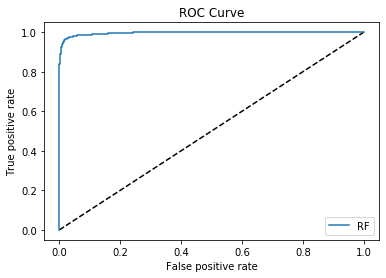

In [40]:
y_pred_proba = clf.predict_proba(X_train)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

### 4.d. Get the test metrics

In [41]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.77      0.68       636
           1       0.43      0.25      0.32       431

    accuracy                           0.56      1067
   macro avg       0.51      0.51      0.50      1067
weighted avg       0.53      0.56      0.53      1067

[[490 146]
 [323 108]]


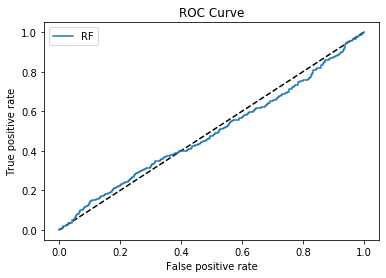

In [42]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

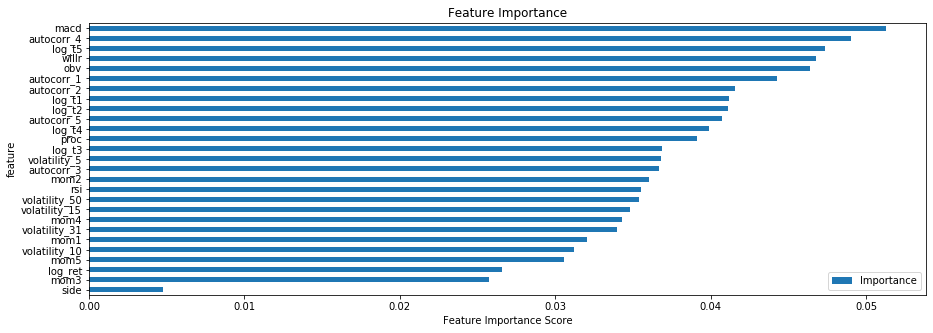

In [43]:
# Feature importance
title = 'Feature Importance'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance': clf.best_estimator_.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=True, inplace=True)
feat_imp.set_index('feature', drop=True, inplace=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

### Performace Tear Sheets

In [44]:
def get_daily_returns(intraday_returns):
    cum_rets = ((intraday_returns + 1).cumprod())
    daily_rets = cum_rets.resample('B').last()
    daily_rets = daily_rets.ffill().pct_change().dropna()
    return pd.Series(daily_rets.values, index=daily_rets.index.tz_localize('UTC'))

#### Without Meta Labeling

In [45]:
valid_dates = X_test.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

In [46]:
pf.show_perf_stats(primary_model_rets)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,-67.1%
Cumulative returns,-39.8%
Annual volatility,80.4%
Sharpe ratio,-0.97
Calmar ratio,-1.32
Stability,0.33
Max drawdown,-50.9%


#### With Meta Labeling

In [47]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)

In [48]:
pf.show_perf_stats(daily_meta_rets)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,51.2%
Cumulative returns,20.8%
Annual volatility,39.1%
Sharpe ratio,1.25
Calmar ratio,4.02
Stability,0.52
Max drawdown,-12.7%


### Performance Analysis

#### Train + Test periods using the primary model

Note: the primary model doesn't use the train dataset to actually 'train' a model. So, the performance in the train period is still relevant.

/home/dan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,73.15,2018-01-10,2018-04-11,NaT,NaN
1,9.05,2018-01-03,2018-01-04,2018-01-05,3
2,6.33,2018-01-08,2018-01-09,2018-01-10,3
3,0.00,2018-01-03,2018-01-03,2018-01-03,1
4,0.00,2018-01-03,2018-01-03,2018-01-03,1


/home/dan/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


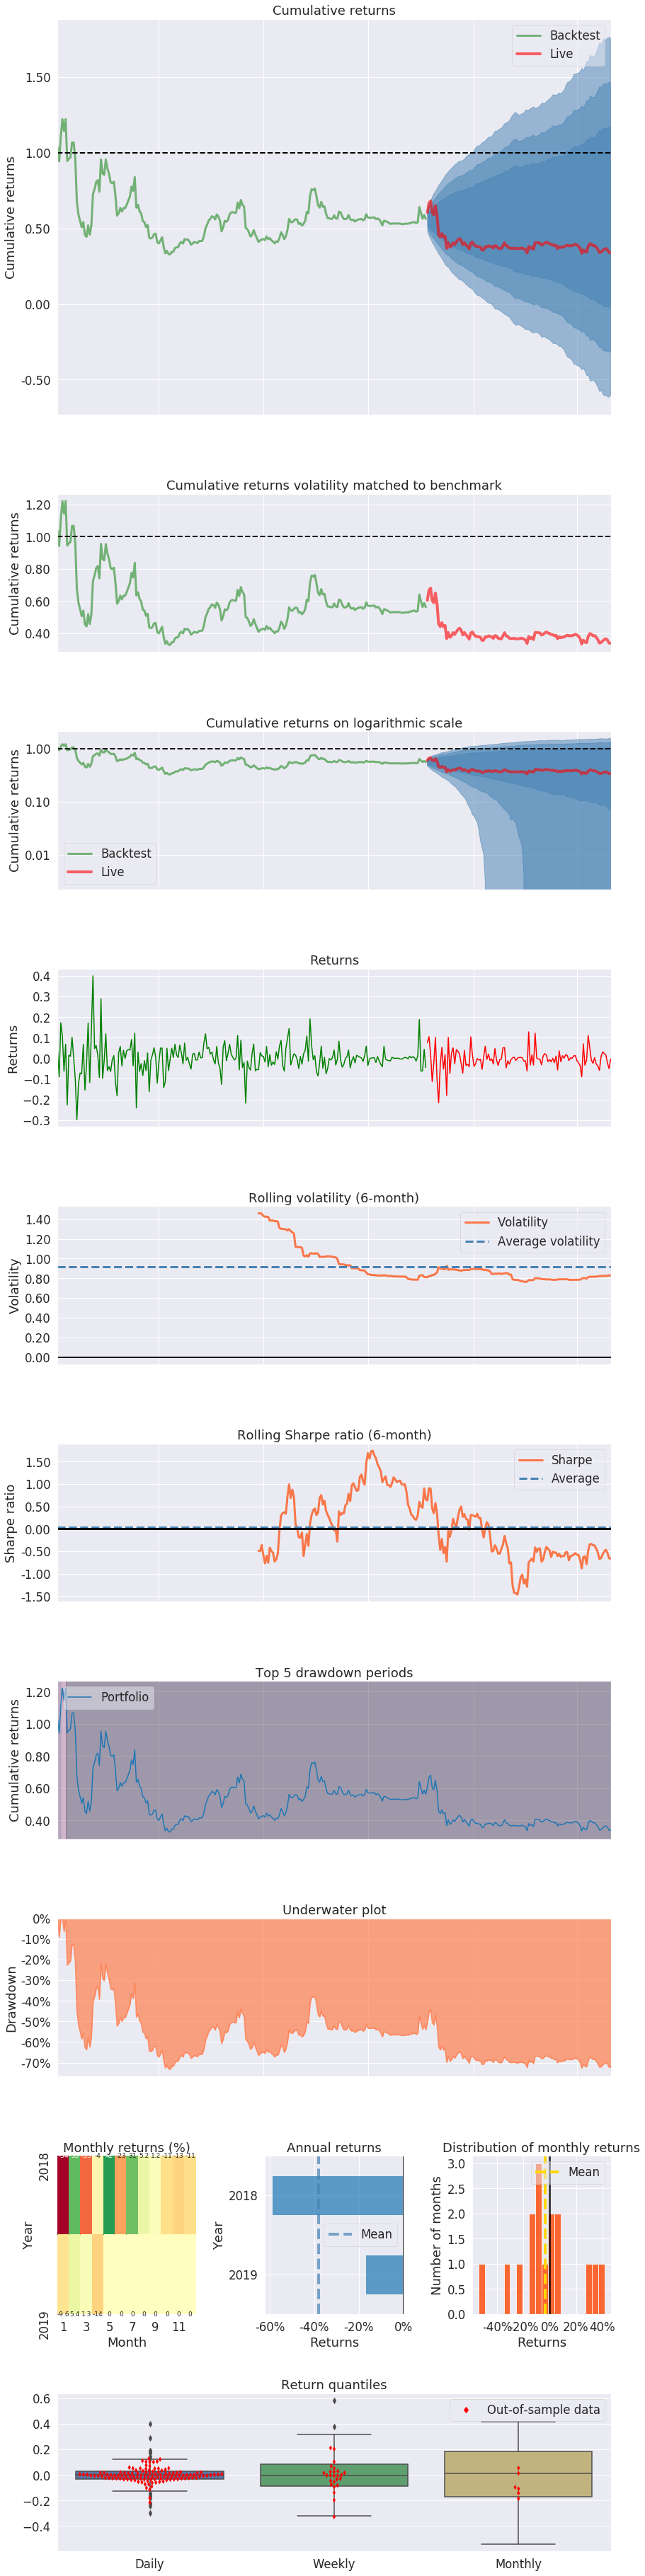

In [49]:
pf.create_returns_tear_sheet(get_daily_returns(labels.ret), live_start_date='2018-11-21')

#### Test period for the secondary model (Random Forest)

Because the train period performance is not relevant, the code below shows only the test performance.

In [50]:
y_pred_test = clf.predict(X_test)

performance = labels.loc[y_test.index, 'ret'] * y_pred_test
daily_performance = get_daily_returns(performance)

Start date,2018-11-21
End date,2019-04-30
Total months,5
,Backtest
Annual return,51.2%
Cumulative returns,20.8%
Annual volatility,39.1%
Sharpe ratio,1.25
Calmar ratio,4.02
Stability,0.52
Max drawdown,-12.7%


/home/dan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.73,2019-04-03,2019-04-30,NaT,NaN
1,11.62,2018-11-22,2018-12-06,2018-12-17,18
2,10.35,2019-02-28,2019-03-18,2019-04-03,25
3,4.41,2019-01-08,2019-01-17,2019-02-01,19
4,4.21,2019-02-05,2019-02-21,2019-02-22,14


/home/dan/.local/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


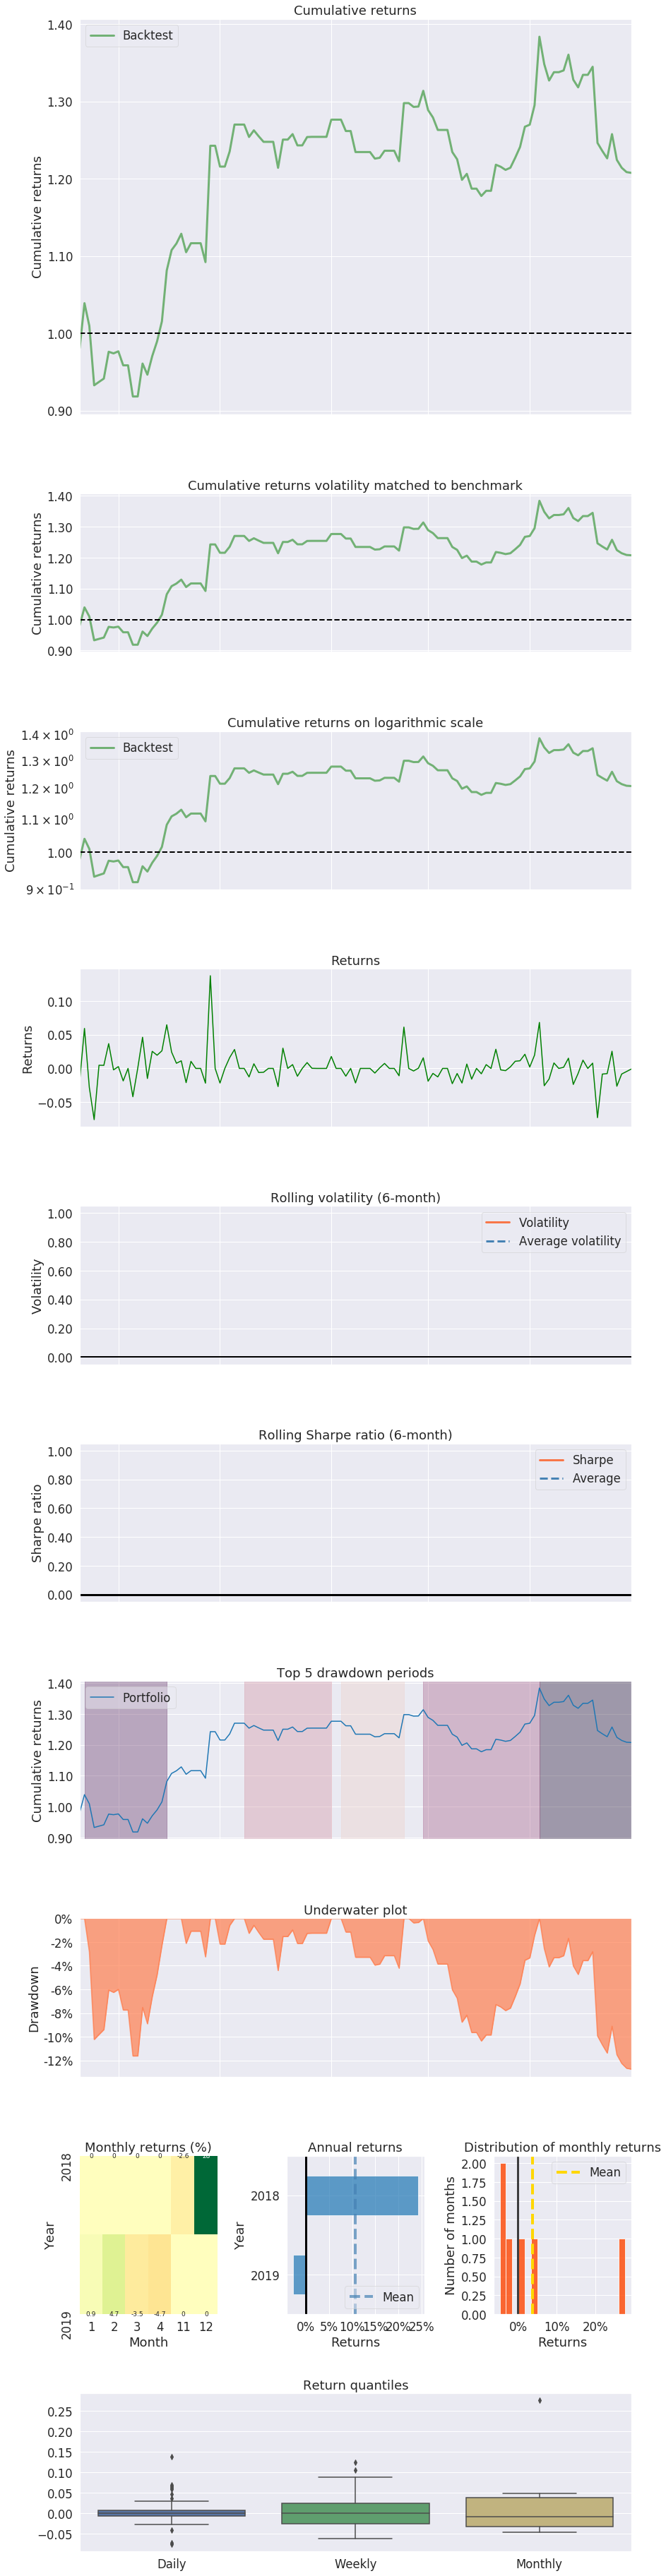

In [51]:
pf.create_returns_tear_sheet(daily_performance)

In [52]:
X

,log_ret,mom1,mom2,mom3,mom4,mom5,volatility_50,volatility_31,volatility_15,volatility_10,...,log_t2,log_t3,log_t4,log_t5,rsi,willr,macd,proc,obv,side
2018-01-02 18:06:53.066,0.004746,0.004757,0.013193,0.007372,0.004106,0.005990,0.006727,0.005922,0.005173,0.006256,...,-0.005762,-0.003247,0.001875,0.005282,58.441111,-80.629540,56.437763,0.136494,-3.752249e+07,1.0
2018-01-02 18:22:07.876,0.005251,0.005265,0.005514,0.020482,0.025337,0.033945,0.006962,0.005994,0.006508,0.005952,...,0.014777,0.004746,0.008360,-0.005762,68.877290,-16.987542,106.936774,3.999269,-9.398534e+06,1.0
2018-01-02 18:29:57.805,0.011369,0.011434,0.016802,0.022155,0.022408,0.037628,0.006972,0.006242,0.006855,0.006314,...,0.005251,0.000247,0.014777,0.004746,75.398481,-25.422483,150.033367,4.384382,9.285178e+06,1.0
2018-01-02 18:36:36.748,0.010195,0.010247,0.012203,0.023776,0.029210,0.034629,0.007025,0.006205,0.006155,0.005947,...,0.011369,0.005294,0.005251,0.000247,79.178104,-22.578763,196.431279,5.803281,2.797105e+07,1.0
2018-01-02 19:20:28.648,0.008100,0.008133,0.012938,0.016052,0.004050,0.013732,0.006290,0.006233,0.006645,0.007382,...,0.003069,-0.011883,0.009597,-0.004997,73.774646,-16.129032,260.055925,4.020979,5.647634e+07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-29 23:13:09.534,0.001362,0.001363,0.004787,0.003611,0.006065,0.009918,0.001740,0.002085,0.002223,0.002703,...,-0.001172,0.002443,0.003823,-0.003529,56.202751,-41.269841,-3.359455,0.233918,-5.478987e+09,-1.0
2019-04-30 11:59:44.853,0.001157,0.001157,0.000964,0.000000,0.000482,0.001544,0.001036,0.001080,0.000979,0.000911,...,-0.000964,0.000482,0.001061,-0.001157,62.784998,-53.125000,8.214588,0.328629,-5.327839e+09,1.0
2019-04-30 13:21:52.564,0.002395,0.002398,0.005098,0.006550,0.005872,0.005775,0.001373,0.001484,0.001375,0.001493,...,0.001444,-0.000674,-0.000096,-0.001827,66.458791,-40.277778,6.779094,0.500096,-5.299691e+09,1.0
2019-04-30 13:22:47.563,0.002653,0.002656,0.005518,0.009166,0.011483,0.013909,0.001517,0.001715,0.001660,0.001790,...,0.003621,0.002294,0.002395,0.002689,81.218553,-43.575419,19.116922,1.546738,-5.262255e+09,1.0


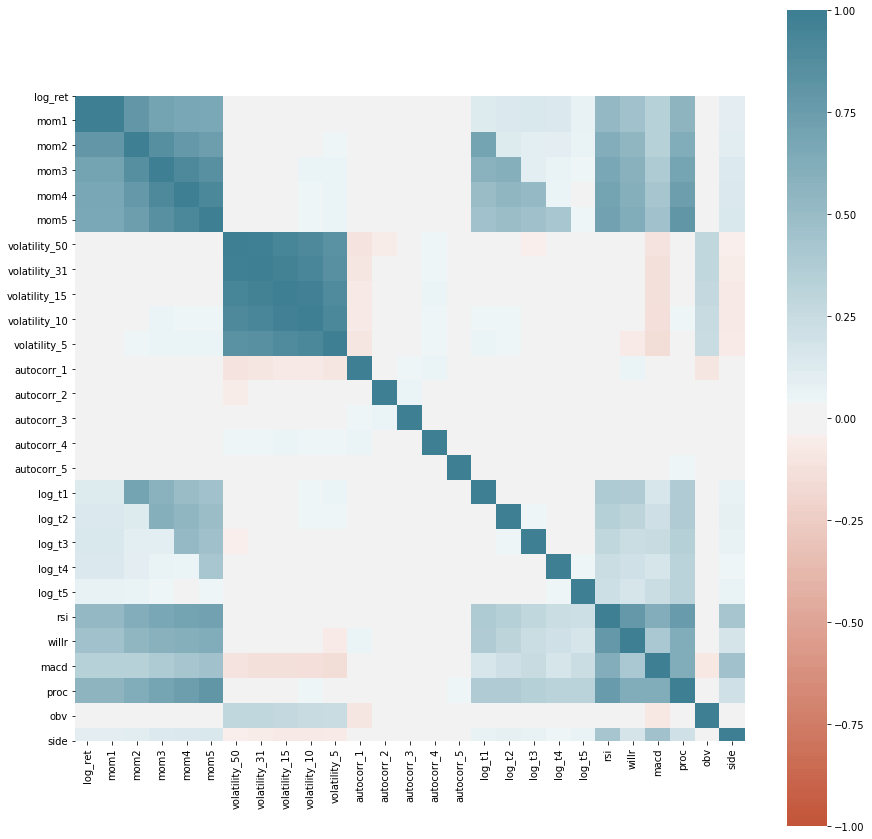

In [59]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [63]:
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X.values)

In [84]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
xs_pca = pca.fit_transform(Xs)

In [85]:
xs_pca

array([[ 3.22118474,  3.62771062, -0.02202811, ..., -0.91813587,
         0.12939348, -0.15646392],
       [ 8.08661631,  3.88489248, -2.06797193, ..., -1.96151571,
         0.55209642,  0.596091  ],
       [10.22972223,  4.02231808, -2.17956144, ..., -1.51526505,
         1.25280044,  0.6378823 ],
       ...,
       [ 2.49037497, -1.44344547,  0.43103308, ...,  0.17124842,
        -0.08321667,  1.72221196],
       [ 4.27378732, -1.46250172, -0.71502627, ..., -0.38458125,
         0.50081222,  0.46107942],
       [-0.40715637, -1.39116439,  0.21574665, ...,  0.80578304,
        -1.25547768,  0.12254269]])

In [86]:
pca.explained_variance_ratio_

array([0.278619  , 0.17921743, 0.06011521, 0.04794241, 0.04491693,
       0.0414179 , 0.03959876, 0.03909979, 0.03737105, 0.03701406,
       0.03605805, 0.0347022 , 0.03311524])

In [87]:
X_tr, X_te, y_tr, y_te = train_test_split(xs_pca, y, test_size=0.25, shuffle=False)

In [95]:
parameters = {'n_estimators': [100, 150, 200],
             'criterion': ['gini', 'entropy'],
             'max_depth': [7, 10, 12, 14, 16],
             'max_features': [None, 'auto'],
             'random_state': [17]}

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='roc_auc', cv=10, n_jobs=-1)

clf.fit(X_tr, y_tr)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [96]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 150,
 'random_state': 17}

In [97]:
clf.best_score_

0.5323319749504263

### 4.c. Get the train metrics

In [98]:
y_pred = clf.predict(X_tr)

print(classification_report(y_tr, y_pred))
print(confusion_matrix(y_tr, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1793
           1       1.00      0.59      0.75      1407

    accuracy                           0.82      3200
   macro avg       0.88      0.80      0.80      3200
weighted avg       0.86      0.82      0.81      3200

[[1792    1]
 [ 571  836]]


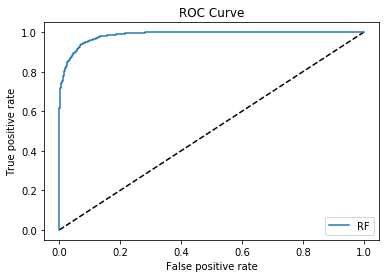

In [99]:
y_pred_proba = clf.predict_proba(X_tr)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_tr, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')

### 4.d. Get the test metrics

In [100]:
y_pred = clf.predict(X_te)

print(classification_report(y_te, y_pred))
print(confusion_matrix(y_te, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.86      0.70       636
           1       0.37      0.12      0.18       431

    accuracy                           0.56      1067
   macro avg       0.48      0.49      0.44      1067
weighted avg       0.50      0.56      0.49      1067

[[550  86]
 [381  50]]


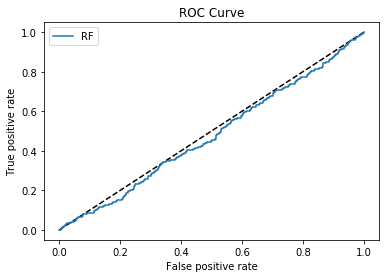

In [101]:
y_pred_proba = clf.predict_proba(X_te)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_te, y_pred_proba)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')